In [1]:
%matplotlib notebook

# general tools
import numpy as np
from numpy import random
import scipy as sp
import newick
import pandas as pd

# dimensionality reduction and visualization
import anndata as ad
from scanpy.api.tl import diffmap
import matplotlib.pyplot as plt
import matplotlib as mpl

/home/npapado/miniconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%load_ext autoreload
%autoreload 2

# tree/simulation
from prosstt import simulation as sim
from prosstt import tree
from prosstt.tree import Tree
from prosstt import tree_utils

In [16]:
random.seed(42)

In [4]:
string1 = '(B:50,(E:50,D:50)C:50)A:50;'
string2 = '(B,(E,D)C)A;'
string3 = '(B:80,C:80)A:80;'
string4 = '(B,C)A;'
tree1 = newick.loads(string1)
tree2 = newick.loads(string2)
tree3 = newick.loads(string3)
tree4 = newick.loads(string4)

In [5]:
t = Tree.from_newick(string4, genes=400)

In [17]:
sample_time = np.arange(0, t.get_max_time())
gene_scale = np.exp(sp.stats.norm.rvs(loc=0.8, scale=1, size=t.G))

In [7]:
def this_simulate_H(K, G, branches, a=0.05):
    coefficients = {}
    for i, branch in enumerate(branches):
        coefficients[branch] = np.reshape(sp.stats.gamma.rvs(a, size=K*G), (K, G))
    return coefficients

In [11]:
alpha = np.exp(random.normal(loc=np.log(0.2), scale=np.log(1.5), size=t.G))
beta = np.exp(random.normal(loc=np.log(1), scale=np.log(1.5), size=t.G)) + 1

In [39]:
HH = this_simulate_H(t.modules, t.G, t.time.keys(), a=0.1)

In [40]:
groups = sim.create_groups(t.modules, t.G)
Hb = {}
for b in t.time.keys():
    Hb[b] = sim.simulate_H(t.modules, t.G, groups)

In [44]:
Ms = {}
while not sim.are_lengths_ok(Ms):
    uMs, Ws, Hs = sim.simulate_branching_data(t, coefficients=Hb)
    for branch in t.time.keys():
        Ms[branch] = np.exp(uMs[branch]) * gene_scale
t.add_genes(Ms)

/home/npapado/miniconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [45]:
X, labs, brns, scalings = sim.sample_data_balanced(1, t.G, t, sample_time, alpha, beta)
# normalize gene expression by library size
X = (X.transpose() / scalings).transpose()

 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.2% 

<IPython.core.display.Javascript object>


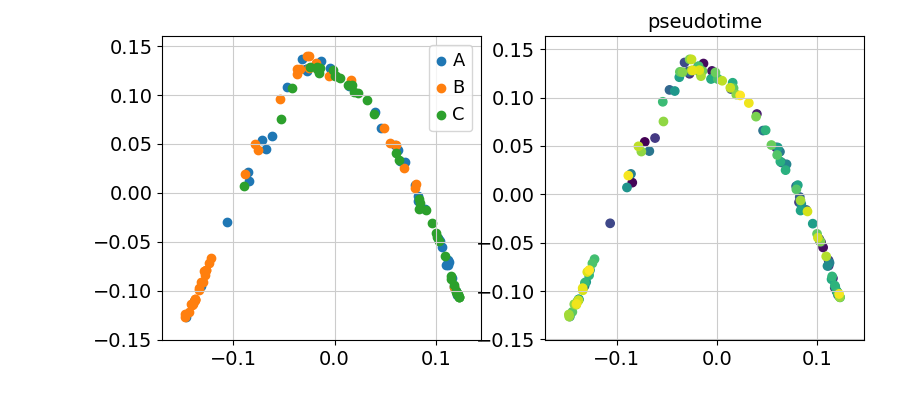

Text(0.5,1,'pseudotime')

In [46]:
data = ad.AnnData(X)
diffmap(adata=data)
dm = data.obsm["X_diffmap"]

fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(w=9, h=4)

for label in np.unique(brns):
    keep = (brns == label)
    ax[0].scatter(dm[keep, 0], dm[keep, 1], label=label)
ax[0].legend()
ax[1].scatter(dm[:, 0], dm[:, 1], c=labs, cmap=plt.get_cmap("viridis"))
ax[1].set_title("pseudotime")